In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from functools import reduce

from FEANet.mesh import MeshSquare
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet

from Utils import plot
from Data.dataset import TestPoissonDataSet

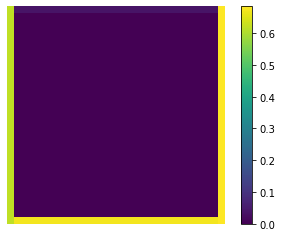

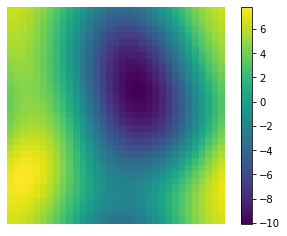

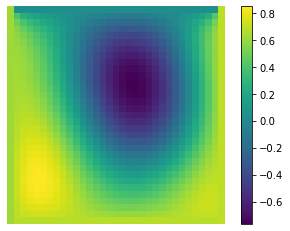

In [2]:
# test on larger grid
training_set = TestPoissonDataSet('Data/TestPoisson/poisson2d_33x33.h5')
bs = 1
train_dataloader = DataLoader(training_set, batch_size=bs, shuffle=False)
dirich_idx_train, dirich_value_train, flux_idx_train, flux_value_train, material_train, f_train, u_train = next(iter(train_dataloader))
k = 0 # the index of training data to be shown

plot.plot_field(dirich_value_train[k,0], fname='Results/bc_value_train.jpg')
plot.plot_field(f_train[k,0], fname='Results/f_train.jpg')
plot.plot_field(u_train[k,0], fname='Results/u_train.jpg')

In [3]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.plate = Geometry(nnode_edge = n+1)
        self.grid = MeshSquare(size, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def IsCoarsest(self):
        return self.n == 2
        
    def ResetBoundary(self, bc_idx, bc_values):
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, bc_idx, bc_values)

    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid).double() # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n).double() # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

In [4]:
n = 2**5
grid = SingleGrid(size=2,n=n)

In [5]:
grid.jac.d_mat

tensor([[[[2.6667, 2.6667, 2.6667,  ..., 2.6667, 2.6667, 2.6667],
          [2.6667, 2.6667, 2.6667,  ..., 2.6667, 2.6667, 2.6667],
          [2.6667, 2.6667, 2.6667,  ..., 2.6667, 2.6667, 2.6667],
          ...,
          [2.6667, 2.6667, 2.6667,  ..., 2.6667, 2.6667, 2.6667],
          [2.6667, 2.6667, 2.6667,  ..., 2.6667, 2.6667, 2.6667],
          [2.6667, 2.6667, 2.6667,  ..., 2.6667, 2.6667, 2.6667]]]])

0 3.7756324604895184
1 2.7943758466214854
2 2.277487344147242
3 1.9523314439744244
4 1.7260216775210884
5 1.557779890767835
6 1.4267468453958692
7 1.32109024373355
8 1.2335753339796944
9 1.159518362976585
10 1.0957472599458453
11 1.0400337853674453
12 0.9907646051511938
13 0.9467414231920156
14 0.9070545839104512
15 0.8710003815834012
16 0.8380253633607896
17 0.8076878513453094
18 0.779630762396993
19 0.7535620266069426
20 0.7292402301399822
21 0.7064639212954144
22 0.6850635309216783
23 0.6648951886842317
24 0.645835934261622
25 0.6277799685978867
26 0.6106356900991444
27 0.5943233298935086
28 0.5787730490259156
29 0.5639233952574095
30 0.5497200422891391
31 0.5361147526225862
32 0.523064518863252
33 0.510530848428518
34 0.49847916427580874
35 0.48687830009081684
36 0.47570007284281224
37 0.4649189190676138
38 0.4545115839281546
39 0.44445685421102615
40 0.4347353280808962
41 0.42532921573490795
42 0.4162221661527269
43 0.4073991159830617
44 0.3988461572887777
45 0.3905504214245236
46

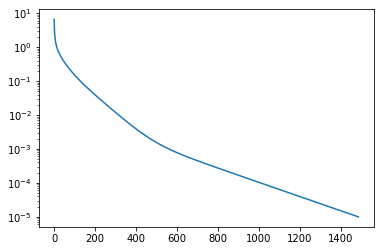

Jacobi solution:


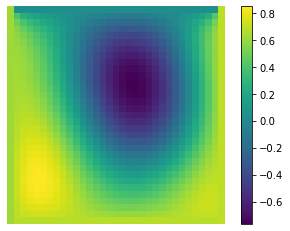

Solution from dataset:


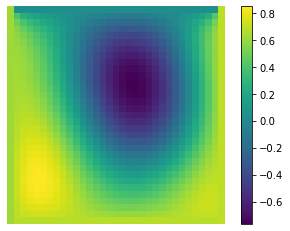

Error (dataset v.s. jacobi):


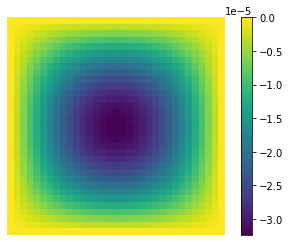

In [6]:
EPS = 1e-5
n_jac = 0
u_test = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_test = grid.fnet(f_train[k,0].reshape((1,1,n+1,n+1))) # assign the finest rhs 
grid.ResetBoundary(dirich_idx_train[k,0].reshape((1,1,n+1,n+1)), dirich_value_train[k,0].reshape((1,1,n+1,n+1)))
u_test = grid.jac.reset_boundary(u_test)
residual = f_test-grid.Knet(u_test)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
res_arr = [res]
while (abs(res) > EPS):
    u_test = grid.jac.jacobi_convolution(u_test, f_test)
    residual = f_test-grid.Knet(u_test)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr.append(res)
    print(n_jac, res)
    n_jac += 1

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')
plt.show()

print("Jacobi solution:")
plot.plot_field(u_test.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. jacobi):")
plot.plot_field(u_train[k,0]-u_test.detach().reshape((1,1,n+1,n+1)))